# Машинное обучение

Достаточно очевидно, что для нашего датасета было бы неплохо обучить модель, предсказывающую цены на машины. В прошлом мы получили финальную версию датасета, убрав оттуда все повторы и пропуски, а также добавив новые признаки. Тем не менее, нужно разобраться с выбросами, так как они могут сильно ухудшить результаты регрессии. 

Начнём с этого!

In [26]:
import pandas as pd
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_percentage_error

In [2]:
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('final_data.csv', index_col='Unnamed: 0')
df.head()

,Модель,Цена,Год выпуска,Пробег,Привод,ЛС,Тип двигателя,Тип кузова,Коробка передач,Объём двигателя,Цвет,Марка,Класс,Налог
0,Kia Carnival IV,4379000,2020,26000,передний,202,Дизель,минивэн,автомат,2.2,чёрный,Kia,4,14443
1,Kia Carnival III,2519000,2018,43000,передний,202,Дизель,минивэн,автомат,2.2,чёрный,Kia,3,13130
2,Tesla Model X Plaid I Рестайлинг,15490000,2022,70,полный,1020,Электро,внедорожник 5 дв.,автомат,2.4,чёрный,Tesla,5,0
3,LADA (ВАЗ) Vesta I,1330000,2021,9000,передний,113,Бензин,седан,вариатор,1.6,белый,LADA,2,2825
4,McLaren 765LT,59500000,2021,1311,задний,765,Бензин,купе,робот,4.0,фиолетовый,McLaren,5,344250


# Предобработка

In [4]:
df.describe(percentiles=[.25, .5, .75, .95, .99])

,Цена,Год выпуска,Пробег,ЛС,Объём двигателя,Класс,Налог
count,2.558000e+03,2558.000000,2558.000000,2558.000000,2558.000000,2558.000000,2558.000000
mean,4.176280e+06,2016.379593,94519.657545,210.232995,2.408249,3.001564,32387.825254
std,5.999969e+06,5.687275,80290.144510,113.675497,0.992336,1.413106,53703.822591
min,3.850000e+04,1961.000000,1.000000,45.000000,0.700000,1.000000,0.000000
25%,1.180000e+06,2013.000000,31000.000000,136.000000,1.600000,2.000000,4550.000000
50%,2.250000e+06,2018.000000,77000.000000,180.000000,2.000000,3.000000,9200.000000
75%,5.127750e+06,2020.000000,142345.750000,249.000000,3.000000,4.000000,37350.000000
95%,1.381500e+07,2022.000000,246208.300000,435.000000,4.500000,5.000000,153000.000000
99%,2.690000e+07,2023.000000,329385.710000,612.000000,6.000000,5.000000,263250.000000
max,1.350000e+08,2023.000000,600000.000000,1020.000000,6.800000,5.000000,344250.000000


Как можно заметить даже отсюда, с большой вероятноcтью в таких признаках, как 'Цена', 'ЛС' и 'Налог' имеются выбросы. Удалим их, чтобы в дальнейшем это не сказалось на качестве модели.

## Пробег

Среди наблюдений есть машины с очень большим пробегом и они составляют очень небольшую часть выборки

<Axes: >

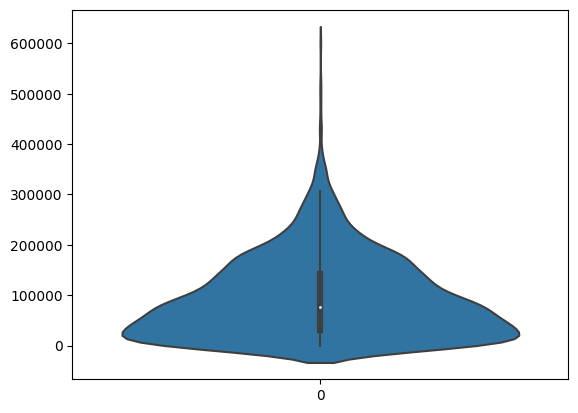

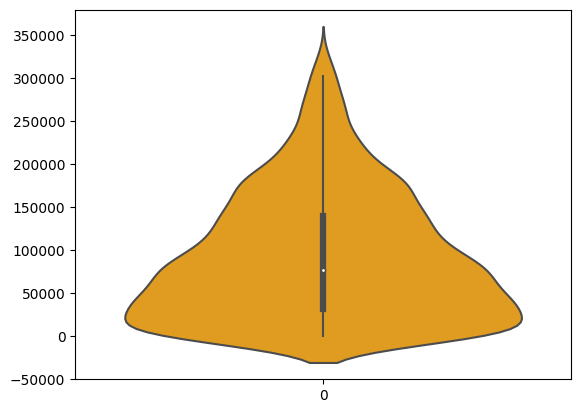

In [5]:
sns.violinplot(data=df['Пробег'])
df = df.loc[df['Пробег'] < df['Пробег'].quantile(0.99)]
plt.figure()
sns.violinplot(data=df['Пробег'], alpha=0.25, color='orange')

Как можно заметить, после того, как мы отсекли данные по 99 квантилю, violinplot стал выглядеть намного более приятно.

## Цена

<Axes: >

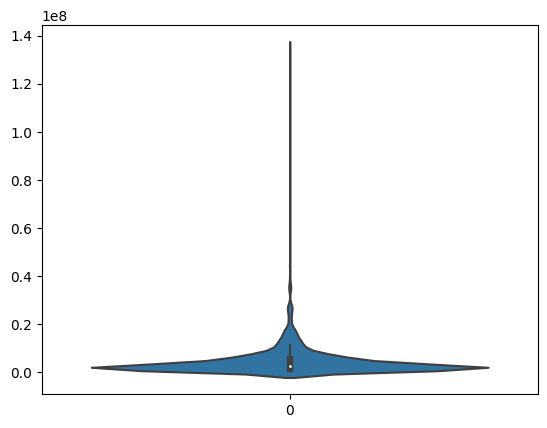

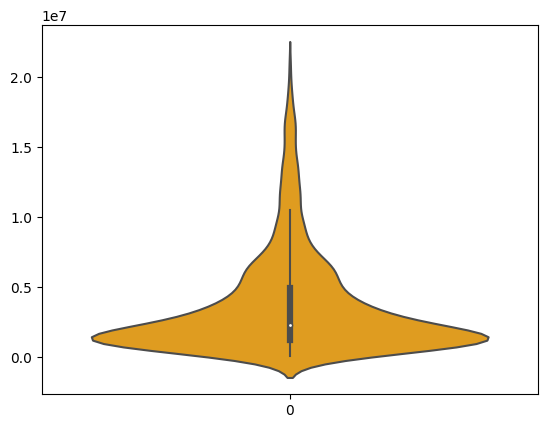

In [6]:
sns.violinplot(data=df['Цена'])
df = df.loc[df['Цена'] < df['Цена'].quantile(0.98)]
plt.figure()
sns.violinplot(data=df['Цена'], alpha=0.25, color='orange')

Как можно заметить, после того, как мы отсекли данные по 98 квантилю, violinplot стал выглядеть намного более приятно.

## ЛС

Сделаем всё то же самое и для машин со слишком высокой мощностью

<Axes: >

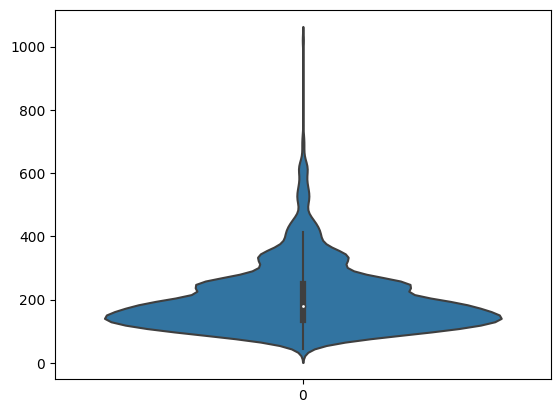

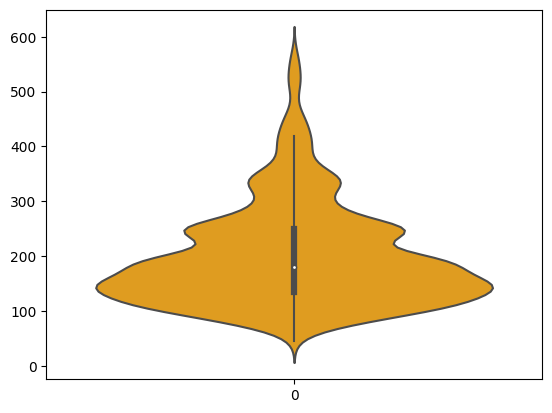

In [7]:
sns.violinplot(data=df['ЛС'])
df = df.loc[df['ЛС'] < df['ЛС'].quantile(0.99)]
plt.figure()
sns.violinplot(data=df['ЛС'], alpha=0.25, color='orange')

## Налоги

Поскольку налог напрямую зависит от цены и лошадиных сил, удаление выбросов по этим параметрам могло удалить и выбросы по размеру налога

<Axes: >

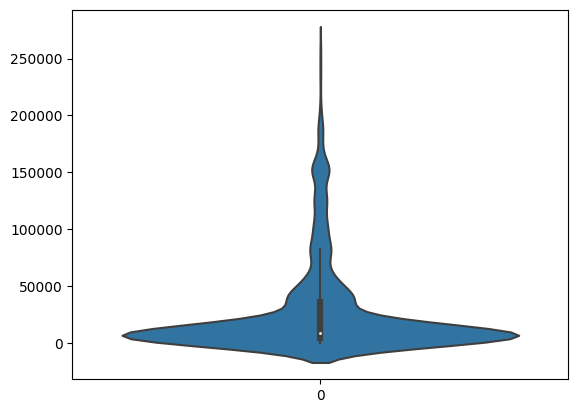

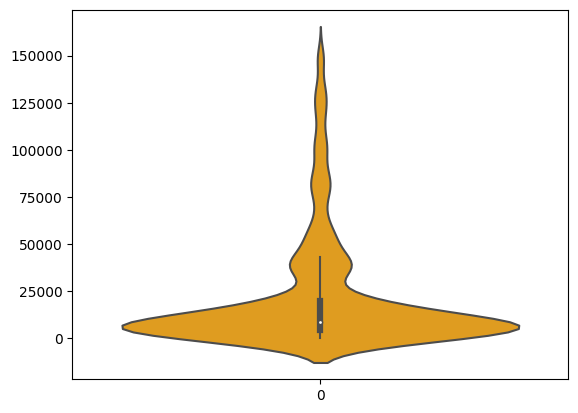

In [8]:
sns.violinplot(data=df['Налог'])
df = df.loc[df['Налог'] < df['Налог'].quantile(0.98)]
plt.figure()
sns.violinplot(data=df['Налог'], alpha=0.25, color='orange')

Отлично! Теперь перейдем к нормализации.

# Нормализация

Как было замечано ранее, в датасете есть как числовые признаки, так и категориальные.

Числовые данные отнормируем при помощи минимаксной процедуры, а категориальные — с помощью метода get_dummies().

In [9]:
df = pd.get_dummies(df)

x_train, x_test, y_train, y_test = train_test_split(df.loc[:, df.columns != 'Цена'],
                                                    df['Цена'], test_size=0.2, random_state=42)

In [10]:
scaler = MinMaxScaler()

x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# Модель

В ходе обучения попробуем как Lasso-регрессия, так и Ridge, а также иные регрессионные методы, потом выберем наилучший результат.

## Lasso-регрессия

In [37]:
alphas = np.linspace(-2, 4, 100)
searcherl = GridSearchCV(Lasso(), [{'alpha': alphas}], scoring="neg_root_mean_squared_error", cv=10, n_jobs=-1)
searcherl.fit(x_train_scaled, y_train)
modell = Lasso(alpha = searcherl.best_params_["alpha"])
modell.fit(x_train_scaled, y_train)
prediction = modell.predict(x_test_scaled)

print(f'MSE: {mean_squared_error(y_test, prediction)}\nMAE: {mean_absolute_error(y_test, prediction)}\nR2 {r2_score(y_test, prediction)} \nMAPE {mean_absolute_percentage_error(y_test, prediction)}')
for col, coef in zip(x_train.columns, modell.coef_):
    print(f'Признак {col} имеет вес {coef}')

MSE: 841215816891.9462
MAE: 514509.51012489153
R2 0.8969632625770875 
MAPE 0.5207317967771605
Признак Год выпуска имеет вес 10136606.44270948
Признак Пробег имеет вес -987496.7267052
Признак ЛС имеет вес -4474437.177481376
Признак Объём двигателя имеет вес 133129.17038480242
Признак Класс имеет вес 1641011.7960447678
Признак Налог имеет вес 6245028.504423424
Признак Модель_Aston Martin DB9 I Рестайлинг 2 имеет вес 4684589.341003466
Признак Модель_Audi A3 35 TFSI IV (8Y) имеет вес 16237.08548738109
Признак Модель_Audi A3 II (8P) Рестайлинг 2 имеет вес -551815.9791704812
Признак Модель_Audi A3 III (8V) Рестайлинг имеет вес -1362239.656520672
Признак Модель_Audi A4 35 TFSI V (B9) Рестайлинг имеет вес -385946.4123530248
Признак Модель_Audi A4 45 TFSI V (B9) Рестайлинг имеет вес 158105.69729118567
Признак Модель_Audi A4 II (B6) имеет вес 1595796.5390389562
Признак Модель_Audi A4 III (B7) имеет вес 823556.7856237744
Признак Модель_Audi A4 V (B9) имеет вес -509252.81561121094
Признак Модель_A

## Ridge регрессия

In [38]:
alphas = np.logspace(-2, 4, 100)
searcherr = GridSearchCV(Ridge(), [{'alpha': alphas}], scoring="neg_root_mean_squared_error", cv=10, n_jobs=-1)
searcherr.fit(x_train_scaled, y_train)
modelr = Ridge(alpha = searcherr.best_params_["alpha"])
modelr.fit(x_train_scaled, y_train)
prediction = modelr.predict(x_test_scaled)

print(f'MSE: {mean_squared_error(y_test, prediction)}\nMAE: {mean_absolute_error(y_test, prediction)}\nR2 {r2_score(y_test, prediction)} \nMAPE {mean_absolute_percentage_error(y_test, prediction)}')
for col, coef in zip(x_train.columns, modelr.coef_):
    print(f'Признак {col} имеет вес {coef}')

MSE: 618626823691.5349
MAE: 472143.4455703745
R2 0.9242271860377268 
MAPE 0.2852677676721085
Признак Год выпуска имеет вес 2490377.0485200263
Признак Пробег имеет вес -1224078.1599499017
Признак ЛС имеет вес -2312874.6782893445
Признак Объём двигателя имеет вес -871700.0870276585
Признак Класс имеет вес 3286474.8327223263
Признак Налог имеет вес 6704547.151177941
Признак Модель_Aston Martin DB9 I Рестайлинг 2 имеет вес 1044219.77383097
Признак Модель_Audi A3 35 TFSI IV (8Y) имеет вес 21480.982681578003
Признак Модель_Audi A3 II (8P) Рестайлинг 2 имеет вес 98044.09303543024
Признак Модель_Audi A3 III (8V) Рестайлинг имеет вес -365770.34511650476
Признак Модель_Audi A4 35 TFSI V (B9) Рестайлинг имеет вес 94285.99109159147
Признак Модель_Audi A4 45 TFSI V (B9) Рестайлинг имеет вес 123601.89670419806
Признак Модель_Audi A4 II (B6) имеет вес 467108.99402365385
Признак Модель_Audi A4 III (B7) имеет вес 237592.79299350645
Признак Модель_Audi A4 V (B9) имеет вес -371178.87688501854
Признак Мод

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.804e+14, tolerance: 1.406e+12
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.022e+14, tolerance: 1.461e+12
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.049e+14, tolerance: 1.494e+12
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.033e+14, tolerance: 1.456e+12
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.879e+14, tolerance: 1.477e+12
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.749e+14, tolerance: 1.403e+12
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.898e+14, tolerance: 1.482e+12
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.033e+14, tolerance: 1.446e+12
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.823e+14, tolerance: 1.383e+12
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.888e+14, tolerance: 1.449e+12
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.835e+14, tolerance: 1.406e+12 Linear regression models with null weight for the l1 regularization term are more efficien

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.876e+14, tolerance: 1.477e+12
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.748e+14, tolerance: 1.403e+12
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.854e+14, tolerance: 1.383e+12 Linear regression models with null weight for the l1 regularization term are more efficien

## GradientBoosting регрессия

In [42]:
modelg = GradientBoostingRegressor(random_state=42)
modelg.fit(x_train_scaled, y_train)
prediction = modelg.predict(x_test_scaled)

print(f'MSE: {mean_squared_error(y_test, prediction)}\nMAE: {mean_absolute_error(y_test, prediction)}\nR2 {r2_score(y_test, prediction)} \nMAPE {mean_absolute_percentage_error(y_test, prediction)}')

MSE: 334879194056.20557
MAE: 375109.3547902766
R2 0.9589821554784224 
MAPE 0.1920195580201132


### Выводы
Самым эффективной моделью (по всем метрикам) оказалась GradientBoosting регрессия с ошибкой 375 тыс рублей, самой эффективной среди линейных - Ridge c подбором параметра через GridSearchCV с ошибкой 472 тыс рублей.

Стоит заметить, что средняя цена на машину в данном датасете - 3 147 820 рублей, то есть ошибка не превышает 20% от цены. В случае с покупокой машины / оценкой стоимости машины такая погрешность не является критичной (если задуматься о прикладной стороне данного проекта), так как разница в 400 тыс при приобретиении машины за 3 млн не сильно влияет на решение о покупке.

Выше можно наблюдать важность различных параметров в линейной модели для определения цены и - что более важно и интересно - их знак.

Так, чёрный, белый и серебристый цвета добавляют в цене, при этом все остальные наоборот (это явление ещё будет описано в гипотезах). Также можно видеть, что год выпуска имеет положительный вес, также как класс автомобиля (потому что, чем выше класс, тем дороже) и размер налога (так как налог зависит от цены и ЛС, а цена зависит от ЛС), меж тем как пробег (что логично), ЛС и объём двигателя влияют отрицательно (что странно, но вероятно может быть объяснено особенностями рынка автомобилей).

Также объяснимы знаки при марках машины - производители более премиального класса добавляют к цене, меж тем как не столь премиального - уменьшают.

В модели с градиентным бустингом используется более сложный алгоритм, предусматривающий обучение на отрицательном градиенте функций потерь при обучении, и поэтому даёт меньшую ошибку и больший коэффицент детерминации, хотя показывает сущесвтенно меньше интересных выводов о ценообразовании на московском авторынке.